# Pipeline for the anomaly detection on the SKAB using LSTM-VAE

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

## Libraries importing

In [1]:
# libraries importing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# additional modules
import sys
sys.path.append('../algorithms')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Data

Put the `data` folder from the SKAB repository in the root of this repository. So the path will be following: `../data/`. Or select your own path.

In [2]:
path_to_data = '../data/'

## Data loading

In [3]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [4]:
# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

### Data description

In [5]:
# dataset characteristics printing
print('SKAB v0.9')
print(f'- A number of datasets: {len(list_of_df)}')
print(f'- Shape of the random dataset: {list_of_df[10].shape}')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'- A number of changepoints: {n_cp}')
print(f'- A number of outliers (point anomalies): {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head(1))

SKAB v0.9
- A number of datasets: 34
- Shape of the random dataset: (1147, 10)
- A number of changepoints: 129
- A number of outliers (point anomalies): 13067

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-01 15:44:06,0.082065,0.133521,1.27794,0.054711,92.2562,22.2577,209.639,76.0197,0.0,0.0


### Data visualization

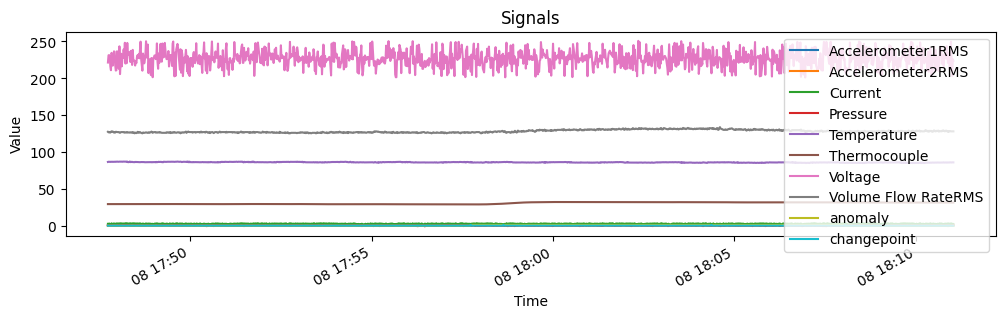

In [6]:
# random dataset visualizing
list_of_df[1].plot(figsize=(12, 3))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

### Labels visualization

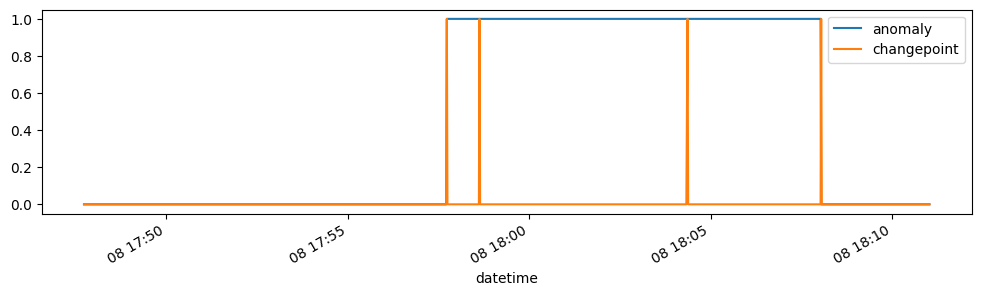

In [7]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[1].anomaly.plot(figsize=(12, 3))
list_of_df[1].changepoint.plot()
plt.legend()
plt.show()

## Method

### Method initialization

In [8]:
from LSTM_VAE import LSTM_VAE
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import numpy as np

In [9]:
# hyperparameters selection
N_STEPS = 5
Q = 0.999 # quantile for upper control limit (UCL) selection

In [10]:
# model defining 
model = LSTM_VAE()

In [11]:
# Generated training sequences for use in the model.
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

### Method fitting and applying

In [12]:
%%time
# inference
predicted_outlier, predicted_cp = [], []
for df in tqdm(list_of_df, desc='1st loop'):
    X_train = df[:400].drop(['anomaly', 'changepoint'], axis=1)
    
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # convert into input/output
    X = create_sequences(StSc.transform(X_train), N_STEPS)
    
    # model fitting
    model.fit(X)
    
    # results predicting
    residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
    UCL = residuals.quantile(Q) * 3/2
    
    # results predicting
    X = create_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
    cnn_residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
    
    # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
    anomalous_data = cnn_residuals > UCL
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)
    
    prediction = pd.Series(data=0, index=df.index)
    prediction.iloc[anomalous_data_indices] = 1
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

1st loop:   0%|          | 0/34 [00:05<?, ?it/s]


KeyboardInterrupt: 

### Results visualization

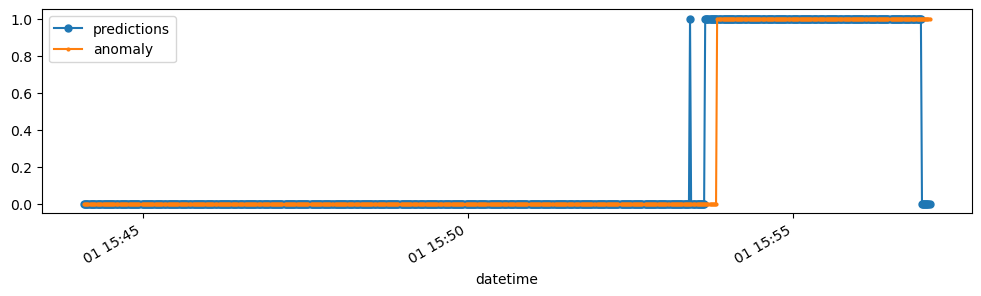

In [13]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend();

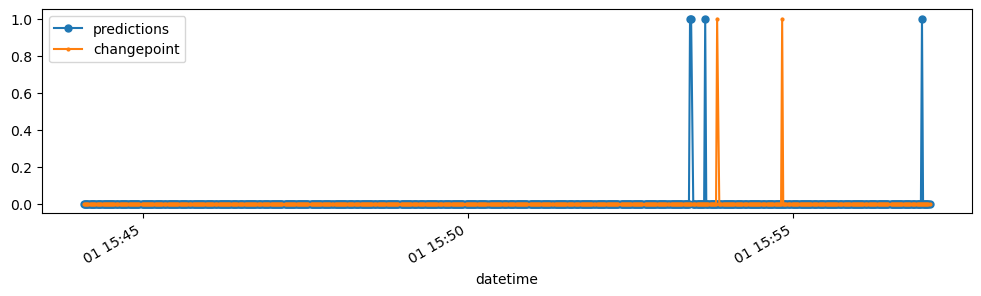

In [14]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

## Evaluation (metrics calculation)

In [15]:
# 'pip install tsad' if needed
from tsad.evaluating.evaluating import evaluating

### Binary classification (outlier detection) metrics

In [16]:
# binary classification metrics calculation
binary = evaluating(
    true_outlier, 
    predicted_outlier, 
    metric='binary'
)

Since you not choose numenta_time and portion, then portion will be 0.1
False Alarm Rate 7.56 %
Missing Alarm Rate 42.05 %
F1 metric 0.67


### Changepoint detection metrics

In [17]:
# average detection delay metric calculation
add = evaluating(
    true_cp, 
    predicted_cp, 
    metric='average_time',
    anomaly_window_destenation='righter', 
    portion=1
)

Intersection of scoring windows(Timestamp('2020-03-01 15:58:10'), Timestamp('2020-03-01 15:54:50'))
Intersection of scoring windows(Timestamp('2020-02-08 18:02:23.600000'), Timestamp('2020-02-08 17:58:38'))
Intersection of scoring windows(Timestamp('2020-02-08 18:09:01.600000'), Timestamp('2020-02-08 18:08:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:24:52.800000'), Timestamp('2020-02-08 18:20:46'))
Intersection of scoring windows(Timestamp('2020-02-08 18:31:06.800000'), Timestamp('2020-02-08 18:28:37'))
Intersection of scoring windows(Timestamp('2020-02-08 18:48:51.600000'), Timestamp('2020-02-08 18:46:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:55:37.600000'), Timestamp('2020-02-08 18:51:55'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:15.800000'), Timestamp('2020-02-08 18:58:30'))
Intersection of scoring windows(Timestamp('2020-02-08 19:06:15.800000'), Timestamp('2020-02-08 19:03:36'))
Intersection of scoring windows(Timestamp('2

In [18]:
# nab metric calculation
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='30S',
    anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-02-08 18:20:42'), Timestamp('2020-02-08 18:20:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:51:37'), Timestamp('2020-02-08 18:51:25'))
Intersection of scoring windows(Timestamp('2020-02-08 19:26:28'), Timestamp('2020-02-08 19:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 17:17:12'), Timestamp('2020-02-08 17:16:43'))
Intersection of scoring windows(Timestamp('2020-02-08 17:24:11'), Timestamp('2020-02-08 17:23:44'))
Standart  -  2.72
LowFP  -  -9.73
LowFN  -  8.53
